# Cycling Performance Estimator

## Set Up

### Dependencies

In [6]:
!pip3 install numpy
!pip3 install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 163kB 2.0MB/s 
     |████████████████████████████████| 61kB 15.8MB/s 
     |████████████████████████████████| 133kB 29.8MB/s 
     |████████████████████████████████| 40.5MB 8.5MB/s 
     |████████████████████████████████| 61kB 11.3MB/s 
     |████████████████████████████████| 143kB 18.9MB/s 
     |████████████████████████████████| 61kB 12.0MB/s 
     |████████████████████████████████| 61kB 17.1MB/s 
     |████████████████████████████████| 358kB 34.2MB/s 
     |████████████████████████████████| 122kB 34.8MB/s 
     |████████████████████████████████| 696kB 40.2MB/s 
     |████████████████████████████████| 491kB 34.1MB/s 
  Running setup.py install for regex ... done
  Running setup.py install for snaptime ... done
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
# For model
import math
import numpy as np
import matplotlib.pyplot as plt

# From Strava API docs
from __future__ import print_function
import time
import swagger_client
from swagger_client.rest import ApiException
from pprint import pprint

### Resources

* https://www.strava.com/settings/api
* http://developers.strava.com/docs/reference/


* https://docs.python.org/2/library/math.html 


* https://docs.python.org/2/library/math.html#trigonometric-functions


* https://www.gribble.org/cycling/power_v_speed.html

## Model

### Calculated power needed to travel a given speed $(v [m/s])$

From Steve Gribble's online power calculator:

![title](./img/gribble_model.png "ShowMyImage")


By default Gribble assumes $C_d A = 0.32067 [m]^2$, $Loss_dt = 2\%$, $\rho = 1.22601 [kg/m^3]$, and $C_{rr} = 0.005$.

$w$ is the weight of the cyclist (+ bike and gear) in $[kg]$.

$G$ is the grade of the road in $[\%]$.
t can be changed).

In [3]:
# In the function below, all inputs with units of %] are entered as decimals, not %s

def p_legs(w, G, v, units = 'imperial'):
    # Model assumptions
    cda = .509*.63 # = 0.32067
    loss_dt = 0.02 # [2%]
    rho = 1.22601
    c_rr = 0.005

    if(units == 'imperial'):
        w = w / 2.20462
        v = v / 2.23694

    # formula assumes SI units
    output_p = pow((1 - loss_dt), -1) * (9.8067 * w * (math.sin(math.atan(G)) + c_rr * math.cos(math.atan(G))) + 
        (0.5 * cda * rho * pow(v, 2))) * v

    # print('p_legs = ' + str(p_legs))
    return output_p

In [23]:
test = p_legs(w = 150, G = 0.05, v = 20, units = 'imperial')

#### Table of power outputs for incremented speed inputs ($G$ held constant)

In [4]:
def table_p_legs_for_varied_v(w, G, v_center, units = 'imperial'):
    input_speeds = np.arange(v_center-4, v_center+4+1, 0.2)    
    arr = np.empty((0,3), float)

    for input_v in input_speeds:
      if(input_v > 0):
        output_p = p_legs(w, G, input_v, units)

        if(units == 'metric'):
          vam =  input_v * math.sin(math.atan(G)) * 3600
        elif(units == 'imperial'):
          vam = input_v * 0.44704 * math.sin(math.atan(G)) * 3600

        arr = np.concatenate((arr, [[input_v, output_p, vam]]), axis=0)
        np.set_printoptions(suppress=True)

    return arr

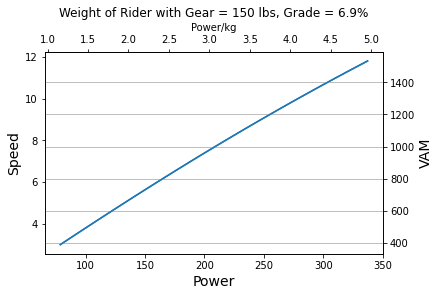

In [8]:
data = table_p_legs_for_varied_v(150, 0.081, 7, units = 'imperial')

fig, ax = plt.subplots(constrained_layout=True)
plt.title('Weight of Rider with Gear = 150 lbs, Grade = 6.9%')

ax.plot(data[:, 1], data[:, 0])
ax.set_xlabel("Power", fontsize=14)
ax.set_ylabel("Speed", fontsize=14)

def power_to_powerperkg(x):
    return x / (150 / 2.20462) # if units = imperial
    return x / 150 # if units = metric

def powerperkg_to_power(x):
    return x * (150 / 2.20462) # if units = imperial
    return x * 150 # if units = metric

secax = ax.secondary_xaxis('top', functions=(power_to_powerperkg, powerperkg_to_power))
secax.set_xlabel('Power/kg')

ax2=ax.twinx()
ax2.plot(data[:, 1], data[:, 2])
ax2.set_ylabel("VAM", fontsize=14)

plt.grid(True)
plt.show()

In [61]:
# Time to finish OLH (Strava ID 8109834)

data = table_p_legs_for_varied_v(150, 0.08, 7, units = 'imperial')

ttf = 2.98 / data[:, 0] * 60

data = np.column_stack((data, ttf))

data

array([[   3.        ,   77.85067516,  385.01248503,   59.6       ],
       [   3.2       ,   83.11182595,  410.67998403,   55.875     ],
       [   3.4       ,   88.38673916,  436.34748303,   52.58823529],
       [   3.6       ,   93.67627492,  462.01498203,   49.66666667],
       [   3.8       ,   98.9812934 ,  487.68248104,   47.05263158],
       [   4.        ,  104.30265474,  513.34998004,   44.7       ],
       [   4.2       ,  109.64121909,  539.01747904,   42.57142857],
       [   4.4       ,  114.9978466 ,  564.68497804,   40.63636364],
       [   4.6       ,  120.37339743,  590.35247704,   38.86956522],
       [   4.8       ,  125.76873172,  616.01997605,   37.25      ],
       [   5.        ,  131.18470962,  641.68747505,   35.76      ],
       [   5.2       ,  136.62219129,  667.35497405,   34.38461538],
       [   5.4       ,  142.08203688,  693.02247305,   33.11111111],
       [   5.6       ,  147.56510653,  718.68997205,   31.92857143],
       [   5.8       ,  153.072260

### Calculated speed from given power $W$

Same assumptions used for $C_d A [m]^2$, $Loss_dt [\%]$, $\rho [kg/m^3]$, and $C_{rr}$

In [5]:
cda = .509*.63 # = 0.32067
loss_dt = 0.02 # [2%]
rho = 1.22601
c_rr = 0.005

In [ ]:
def vel(w, G, plegs, units = 'imperial'):
    # Model assumptions
    cda = .509*.63 # = 0.32067
    loss_dt = 0.02 # [2%]
    rho = 1.22601
    c_rr = 0.005
    
    if(units == 'imperial'):
        w = w / 2.20462
        v = v / 2.23694

## Figuring Out How to Use the Strava API

* Strava's documentation confuses me.
    I'm not sure how to use the swagger_client



### Strava Oauth

https://github.com/sladkovm/strava-oauth

* Use this if the Stravio "Before Use" steps (here: https://github.com/sladkovm/stravaio) aren't working

* Lightweight python server that implements Strava Oauth Web Flow

The result of follwing the "Quick Start" section on the repository readme:

In [ ]:
{
    "token_type":"Bearer",
    "expires_at":1587032668,
    "expires_in":21600,
    "refresh_token":"a85ca4b26b06744e5cbdce07fd87c639a7d4c133",
    "access_token":"65d10ff46f93d87f52c933185f7215454691cd35",
    "athlete": {
        "id":17194123,
        "username":"josh_rr",
        "resource_state":2,
        "firstname":"Josh",
        "lastname":"Ruby",
        "city":"",
        "state":"",
        "country":"",
        "sex":"M",
        "premium":true,
        "summit":true,
        "created_at":"2016-08-27T22:06:09Z",
        "updated_at":"2020-04-07T22:55:56Z",
        "badge_type_id":1,
        "profile_medium":"https://dgalywyr863hv.cloudfront.net/pictures/athletes/17194123/9664082/1/medium.jpg",
        "profile":"https://dgalywyr863hv.cloudfront.net/pictures/athletes/17194123/9664082/1/large.jpg",
        "friend":null,
        "follower":null
    }
}

### Stravaio

I can approve access to my account and pull API info using Stravio!

I'm currently not sure whether segment data is accessible via their wrapper. This shouldn't be difficult to figure out.

#### Before Use

In [37]:
from stravaio import strava_oauth2

!pip3 install python-dotenv
import dotenv

strava_oauth2(client_id=45520, client_secret='ca22713c82948cee145911075f42ea2a830cf9a5')

You should consider upgrading via the 'pip install --upgrade pip' command.
2020-04-15 22:27:25.106 | INFO     | stravaio:strava_oauth2:343 - serving at port 8000
2020-04-15 22:27:27.449 | DEBUG    | stravaio:run_server_and_wait_for_token:397 - code: fd3f46c6447a33ecbb1929497838720327ddc5f8
2020-04-15 22:27:27.834 | DEBUG    | stravaio:run_server_and_wait_for_token:406 - Authorized athlete: 65d10ff46f93d87f52c933185f7215454691cd35


{'token_type': 'Bearer',
 'expires_at': 1587032668,
 'expires_in': 17821,
 'refresh_token': 'a85ca4b26b06744e5cbdce07fd87c639a7d4c133',
 'access_token': '65d10ff46f93d87f52c933185f7215454691cd35',
 'athlete': {'id': 17194123,
  'username': 'josh_rr',
  'resource_state': 2,
  'firstname': 'Josh',
  'lastname': 'Ruby',
  'city': '',
  'state': '',
  'country': '',
  'sex': 'M',
  'premium': True,
  'summit': True,
  'created_at': '2016-08-27T22:06:09Z',
  'updated_at': '2020-04-07T22:55:56Z',
  'badge_type_id': 1,
  'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/17194123/9664082/1/medium.jpg',
  'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/17194123/9664082/1/large.jpg',
  'friend': None,
  'follower': None}}

#### Use

In [38]:
from stravaio import StravaIO

# If the token is stored as an environment varible it is not neccessary
# to pass it as an input parameters
client = StravaIO(access_token=STRAVA_ACCESS_TOKEN)

#### Athlete

In [39]:
# Get logged in athlete (e.g. the owner of the token)
# Returns a stravaio.Athlete object that wraps the
# [Strava DetailedAthlete](https://developers.strava.com/docs/reference/#api-models-DetailedAthlete)
# with few added data-handling methods
athlete = client.get_logged_in_athlete()

# Dump athlete into a JSON friendly dict (e.g. all datetimes are converted into iso8601)
athlete_dict = athlete.to_dict()

# Store athlete infor as a JSON locally (~/.stravadata/athlete_<id>.json)
athlete.store_locally()

# Get locally stored athletes (returns a generator of dicts)
local_athletes = client.local_athletes()

In [41]:
athlete_dict

{'id': 17194123,
 'resource_state': 3,
 'firstname': 'Josh',
 'lastname': 'Ruby',
 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/17194123/9664082/1/medium.jpg',
 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/17194123/9664082/1/large.jpg',
 'city': '',
 'state': '',
 'country': '',
 'sex': 'M',
 'friend': None,
 'follower': None,
 'premium': True,
 'summit': True,
 'created_at': '2016-08-27T22:06:09Z',
 'updated_at': '2020-04-07T22:55:56Z',
 'follower_count': 24,
 'friend_count': 51,
 'mutual_friend_count': 0,
 'measurement_preference': 'feet',
 'ftp': 175,
 'weight': 60.3278,
 'clubs': [{'id': 230912,
   'resource_state': 2,
   'name': 'Shenanigans Arianimals Cycling',
   'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/clubs/230912/5086920/1/medium.jpg',
   'cover_photo': 'https://dgalywyr863hv.cloudfront.net/pictures/clubs/230912/5086915/1/large.jpg',
   'cover_photo_small': 'https://dgalywyr863hv.cloudfront.net/picture

### Vanilla Strava API

Having trouble with the vanilla API still...

I suspect I need to be running a local server using Maven 

In [ ]:
# https://github.com/swagger-api/swagger-codegen#compatibility

# Preqreqs
!brew cask install homebrew/cask-versions/adoptopenjdk8
!export JAVA_HOME=`/usr/libexec/java_home -v 1.8`
!export PATH=${JAVA_HOME}/bin:$PATH

!brew install maven
!sudo ln -sfn /usr/local/opt/openjdk/libexec/openjdk.jdk /Library/Java/JavaVirtualMachines/openjdk.jdk
!echo 'export PATH="/usr/local/opt/openjdk/bin:$PATH"' >> ~/.zshrc
!export M2_HOME=/usr/local/Cellar/maven/3.5.0/libexec
!export M2=${M2_HOME}/bin
!export PATH=${PATH}:${M2_HOME}/bin

# !mvn clean package

# Main package
!brew install swagger-codegen

In [46]:
# http://developers.strava.com/docs/reference/
# Get Athlete Stats (getStats)

from __future__ import print_function
import time
import swagger_client
from swagger_client.rest import ApiException
from pprint import pprint

# Configure OAuth2 access token for authorization: strava_oauth
swagger_client.configuration.access_token = STRAVA_ACCESS_TOKEN

# create an instance of the API class
api_instance = swagger_client.AthletesApi()
id = 56 # Integer | The identifier of the athlete. Must match the authenticated athlete.

try: 
    # Get Athlete Stats
    api_response = api_instance.getStats(id)
    pprint(api_response)
except ApiException as e:
    print("Exception when calling AthletesApi->getStats: %s\n" % e)

AttributeError: 'AthletesApi' object has no attribute 'getStats'